# Загрузим данные

In [ ]:
!kaggle datasets download aungpyaeap/supermarket-sales -p C:\Files\Программирование\Портфолио\RFM-analysis\data

In [ ]:
import os
from shutil import unpack_archive

unpack_archive('data/supermarket-sales.zip', './data', 'zip')

os.remove('data/supermarket-sales.zip')

# Импортируем библиотеки

In [1]:
import pandas as pd

# Короткий EDA

In [2]:
df = pd.read_csv('data/supermarket_sales - Sheet1.csv')

In [3]:
df.head()

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761905,30.2085,5.3


В ходе RFM анализа надо будет разделить покупателей на 27 категорий по дате последенй покупки, количеству покупок и сумме потрченных средств  
  
Так как датасет сгенерированный, то убедимся, что не все пользователи уникальны

In [5]:
df['Invoice ID'].nunique()

1000

In [6]:
df.shape[0]

1000

К сожалению, все пользователи уникальные, попробуем изменить ситуацию

In [7]:
df['Invoice ID'].apply(lambda x: x.split('-')[0]).nunique()

575

In [9]:
df['Invoice ID'].apply(lambda x: '-'.join(x.split('-')[:2])).nunique()

999

Оставив только первое число в id, получаем 575 уникальных пользователей.  Заменим данные в датасете

In [11]:
df['Invoice ID'] = df['Invoice ID'].apply(lambda x: x.split('-')[0])

In [12]:
df['Invoice ID'].nunique()

575

Оставим только нужные для анализа столбцы

In [14]:
cols = ['Invoice ID', 'Total', 'Date']

df_need_cols = df[cols]

In [15]:
df_need_cols

,Invoice ID,Total,Date
0,750,548.9715,1/5/2019
1,226,80.2200,3/8/2019
2,631,340.5255,3/3/2019
3,123,489.0480,1/27/2019
4,373,634.3785,2/8/2019
...,...,...,...
995,233,42.3675,1/29/2019
996,303,1022.4900,3/2/2019
997,727,33.4320,2/9/2019
998,347,69.1110,2/22/2019


Переименуем наконец столбец с id

In [ ]:
df_need_cols.rename(columns={'Invoice ID': 'id'}, inplace=True)

Посмотрим типы и приведем к нужным

In [17]:
df_need_cols.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      1000 non-null   object 
 1   Total   1000 non-null   float64
 2   Date    1000 non-null   object 
dtypes: float64(1), object(2)
memory usage: 23.6+ KB


In [ ]:
df_need_cols['id'] = df_need_cols['id'].astype('int')
df_need_cols['Date'] = pd.to_datetime(df_need_cols['Date'])

Посмотрим на распределение

In [20]:
df_need_cols.describe()

,id,Total,Date
count,1000.000000,1000.000000,1000
mean,504.837000,322.966749,2019-02-14 00:05:45.600000
min,101.000000,10.678500,2019-01-01 00:00:00
25%,302.750000,124.422375,2019-01-24 00:00:00
50%,510.000000,253.848000,2019-02-13 00:00:00
75%,712.500000,471.350250,2019-03-08 00:00:00
max,898.000000,1042.650000,2019-03-30 00:00:00
std,230.311232,245.885335,NaN


Сразу заметно, что диапазон дат у нас всего 3 месяца, тогда по месяцам и поделим на 3 категории, в сумме покупки без пропусков. Более точно рассматривать данные не имеет смысла - переходим к анализу

# RFM-анализ

## Recency (давность)

In [ ]:
df_need_cols['date cat'] = df_need_cols['Date'].dt.month

## Frequency (частота)

In [29]:
order_count = df_need_cols.groupby('id').size().reset_index(name='count')

In [32]:
df_with_count = df_need_cols.merge(order_count, on='id', how='left')

<Axes: xlabel='count'>

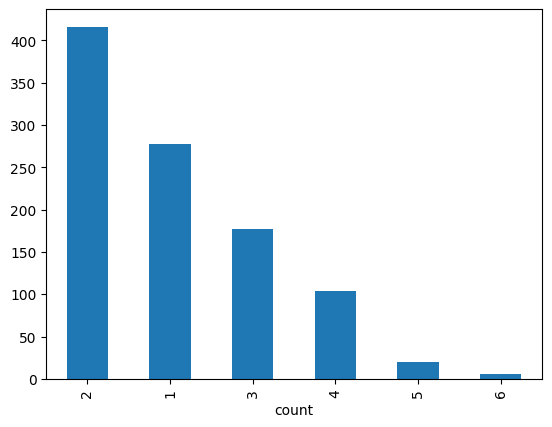

In [41]:
df_with_count['count'].value_counts().plot(kind='bar')

Разобъем следующим образом:  
 - 1 и 2 - покупают редко (1)
 - 3 - покупают иногда (2)
 - 4, 5 и 6 - покупают часто (3)

In [43]:
mapping = {1: 1, 2: 1, 3: 2, 4: 3, 5: 3, 6: 3}

df_with_count['count cat'] = df_with_count['count'].map(mapping)

## Сумма (Monetary)

In [45]:
grandtotal = df_with_count.groupby('id')['Total'].agg('sum').reset_index(name='grandtotal')

In [47]:
df_with_grandtotal = df_with_count.merge(grandtotal, on='id', how='left')

In [49]:
df_with_grandtotal['grandtotal'].describe()

count    1000.000000
mean      712.895085
std       536.225395
min        13.419000
25%       308.361375
50%       580.083000
75%       972.100500
max      3319.155000
Name: grandtotal, dtype: float64

<Axes: >

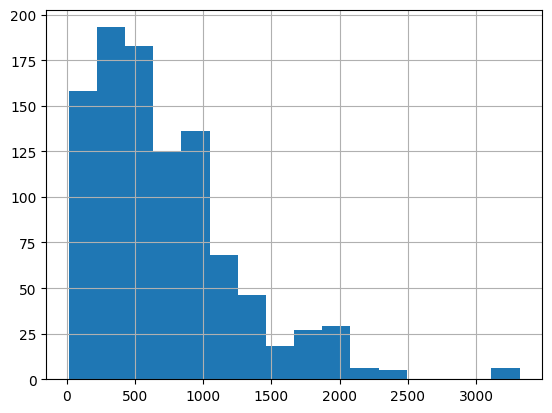

In [51]:
df_with_grandtotal['grandtotal'].hist(bins=16)

Подберем разбиение на группы

In [52]:
mean = df_with_grandtotal['grandtotal'].mean()
std = df_with_grandtotal['grandtotal'].std()

Посмотрим сколько значений лежать относительно среднего и нескольких стандартных отклонений  
  
Всего у нас 575 покупателей

In [64]:
all_customers = df_with_grandtotal['id'].nunique()

In [66]:
100 * (df_with_grandtotal.loc[df_with_grandtotal['grandtotal'] < mean, 'id'].nunique() / all_customers)

70.6086956521739

In [68]:
100 * (df_with_grandtotal.loc[df_with_grandtotal['grandtotal'] <= mean + std, 'id'].nunique() / all_customers)

92.8695652173913

In [70]:
100 * (df_with_grandtotal.loc[df_with_grandtotal['grandtotal'] <= mean + 2 * std, 'id'].nunique() / all_customers)

97.3913043478261

Разделим по сумме покупок ледующим образом:  
 - Меньше среднего (1)
 - От среднего до одного стандартного отклонения (2)
 - больше одного стандартного отклонения (3)

In [71]:
def calc_grandtotal_cats(value):
    if value <= mean:
        return 1
    elif value <= mean + std:
        return 2
    else:
        return 3
    
df_with_grandtotal['grandtotal cat'] = df_with_grandtotal['grandtotal'].apply(calc_grandtotal_cats)

Перепроверим результаты

In [78]:
100 * (df_with_grandtotal.loc[df_with_grandtotal['grandtotal cat'] == 3, 'id'].nunique() / all_customers)

7.130434782608695

In [79]:
100 * (df_with_grandtotal.loc[df_with_grandtotal['grandtotal cat'] == 2, 'id'].nunique() / all_customers)

22.26086956521739

In [80]:
100 * (df_with_grandtotal.loc[df_with_grandtotal['grandtotal cat'] == 1, 'id'].nunique() / all_customers)

70.6086956521739

In [81]:
df_with_grandtotal.head()

,id,Total,Date,date cat,count,count cat,grandtotal,grandtotal cat
0,750,548.9715,2019-01-05,1,2,1,739.5675,2
1,226,80.2200,2019-03-08,3,3,2,362.5335,1
2,631,340.5255,2019-03-03,3,2,1,417.1020,1
3,123,489.0480,2019-01-27,1,2,1,929.9850,2
4,373,634.3785,2019-02-08,2,4,3,1787.1840,3


## Разделим на 27 категорий

In [87]:
df_with_grandtotal['all cats'] = (df_with_grandtotal['date cat'].astype('str') + df_with_grandtotal['count cat'].astype('str') + df_with_grandtotal['grandtotal cat'].astype('str')).astype('int')

In [98]:
df_with_grandtotal['rfm rank'] = df_with_grandtotal['all cats'].rank(method='dense').astype('int')

In [101]:
df_with_grandtotal.head()

,id,Total,Date,date cat,count,count cat,grandtotal,grandtotal cat,all cats,rfm rank
0,750,548.9715,2019-01-05,1,2,1,739.5675,2,112,2
1,226,80.2200,2019-03-08,3,3,2,362.5335,1,321,22
2,631,340.5255,2019-03-03,3,2,1,417.1020,1,311,19
3,123,489.0480,2019-01-27,1,2,1,929.9850,2,112,2
4,373,634.3785,2019-02-08,2,4,3,1787.1840,3,233,18


# Выводы

В данном анализе , мы взяли датасет и с небольшими манипуляциями подготовили его для RFM-анализа.  
В ходе анализа, мы проставили категории для 3 величи (дата последней покупки, количство покупок и сумма всех покупок).  
На основании полученны категорий мы разделили пользователей на 27 групп, где первая группа потратила меньше всех, давно делала последнюю покупку и потратила меньше других групп, а 27 группа тратила больше остальных, покупала 4 и более раз, а так же была в магазине в течении последнего месяца. 
  
На основании полученных результатов, можно планировать свое взаимодействие с клиентами. Возможно подробнее оценить в какие именно категории входит каждая их групп, в каком магазине какая из груп преобладает и т.д.